# Performance evaluation and benchmarking

In this notebook we will go step-by-step through the model evaluation part of our paper, where we compare the predictions of the XGBoost and EA-LSTM models.

Note:
If you want to run this notebook locally and reproduce the figures of our paper
- make sure you have the models' predictions. See the `README.md` in the repository for further instructions.

- make sure to have the CAMELS benchmark data set. See the `README.md` in the repository for further instructions.

#### Adapt the lines below according to your local system

In [1]:
# Needed if no precomputed results are used. Main directory containing all runs
BASE_RUN_DIR = "/home/mgauch/ealstm_regional_modeling/runs/run_grid_1812_1149/"

# Path to CAMELS data
CAMELS_DIR = "/home/mgauch/ealstm_regional_modeling/data/CAMELS"

# Path to the main directory of this repository
BASE_CODE_DIR = "/home/mgauch/ealstm_regional_modeling"

In [2]:
# Imports
import pickle
import sys
from collections import defaultdict
from pathlib import Path
import itertools
import os

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import pandas as pd
import tqdm
from scipy.stats import wilcoxon, ks_2samp
from sklearn.metrics import auc

# Add repository to Python path
sys.path.append(BASE_CODE_DIR)
from papercode.plotutils import (model_draw_style, model_specs_gridEvaluation, 
                                 ecdf, get_shape_collections)
from papercode.evalutils import (get_run_dirs_gridEvaluation, eval_datadriven_models, 
                                 eval_benchmark_models, get_pvals, 
                                 get_mean_basin_performance, get_cohens_d)
from papercode.datautils import load_attributes, add_camels_attributes
from papercode.utils import get_basin_list

from papercode.metrics import *

Definition of global variables. 

**Note**: If you want to recompute all model metrics, change the `PRECOMPUTED_DATA` flag to `False`. No GPU is required. If you want to use the pre-calculated metrics, make sure the flag is set to `True`

In [3]:
# If True load pre-computed metrics from pickle file, else re-calculate everything
PRECOMPUTED_DATA = True

# Convert to PosixPaths
BASE_RUN_DIR = Path(BASE_RUN_DIR)
BASE_CODE_DIR = Path(BASE_CODE_DIR)
CAMELS_DIR = Path(CAMELS_DIR)

seq_lens = {'ealstm': [10, 30, 100, 270, 365],
            'xgboost': [10, 30, 100]}

# Set of evaluation functions
EVAL_FUNCS = {'NSE': calc_nse,
              'alpha_nse': calc_alpha_nse, 
              'beta_nse': calc_beta_nse,
              'FHV': calc_fdc_fhv, 
              'FLV': calc_fdc_flv, 
              'FMS': calc_fdc_fms}

# Evaluate data-driven models

First, we compare the XGBoost models with EA-LSTM models on different amounts of training data. There are 3*5*5 different setups, resulting from the combinations of the following dimensions:

1. Number of training years: 3, 6, or 9
2. Number of basins: 13, 26, 53, 265, or 531
3. Sequence length: 10, 30, 100, 270, or 365 (XGBoost: only 10, 30, 100)

For each of these settings, we trained 8 models (using different random initializations). We combined these 8 models to an ensemble (by averaging the k=8 model simulations), which is what we evaluate here.

To account for differences in the basins, we evaluate the performance on 13, 26, 53 and 265 basins on five different random basin subsets.

In [4]:
if PRECOMPUTED_DATA:
    print("Loaded data from pre-computed pickle file")
    with open(BASE_RUN_DIR / "all_metrics_gridEvaluation.p", "rb") as fp:
        all_metrics = pickle.load(fp)
else:
    all_metrics = {}
    for func_name, func in EVAL_FUNCS.items():
        tqdm.tqdm.write(f"Calculating metric: {func_name}")
        model_metrics = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
        for (model, _, _), training_years, n_basins in itertools.product(model_specs_gridEvaluation['models'], 
                                                                         model_specs_gridEvaluation['training_years'], 
                                                                         model_specs_gridEvaluation['n_basins']):
            for seq_len in seq_lens[model]:
                tqdm.tqdm.write(f"Model: {model}, Training years: {training_years}, number of basins: {n_basins}, seq_len: {seq_len}")
                for basin_subset in model_specs_gridEvaluation['basin_subsets'][n_basins]:
                    run_dirs = get_run_dirs_gridEvaluation(root_dir=BASE_RUN_DIR / str(seq_len), model=model, 
                                                           basin_subset=basin_subset, training_years=training_years)
                    model_metrics[model][training_years][seq_len][basin_subset] = eval_datadriven_models(run_dirs=run_dirs, func=func)
        
        all_metrics[func_name] = model_metrics                    

Loaded data from pre-computed pickle file


## Tabular comparison

In a first step, we look at the mean, median NSE as well as the number of catastrophic failures. Catastrophic failures are defined as the number of basins, where the model has a NSE <= 0.
We calculate the mean of each of this three statistics over the model (n=8) model repetitions and the random basin samples and report the standard deviation here as well. The repetitions are denoted as `ensemble=False` in the table below.

In [5]:
data = []
for model, model_label, _ in model_specs_gridEvaluation['models']:
    for training_years, n_basins, seq_len in itertools.product(model_specs_gridEvaluation['training_years'], 
                                                               model_specs_gridEvaluation['n_basins'], 
                                                               seq_lens[model]):
        ensemble_nses = []
        means, medians, failures, mins, maxs = [], [], [], [], []
        for basin_subset in model_specs_gridEvaluation['basin_subsets'][n_basins]:
            models = all_metrics['NSE'][model][training_years][seq_len][basin_subset]
            seeds = [k for k in models.keys() if "seed" in k]
            if len(seeds) == 0:
                print(f"No data for {model}, {training_years} years, {seq_len} seq_len, {n_basins} basins (subset no. {basin_subset})")
                continue
            for seed in seeds:
                values = list(models[seed].values())
                mins.append(np.min(values))
                maxs.append(np.max(values))
                means.append(np.mean(values))
                medians.append(np.median(values))
                failures.append(len([v for v in values if v <= 0]))
            ensemble_nses += list(models["ensemble"].values())
            
        if len(ensemble_nses) == 0:
            print(f"No results for {model}, {training_years} years, {seq_len} seq_len, {n_basins} basins")
            continue
            
        num_subsets = len(model_specs_gridEvaluation['basin_subsets'][n_basins])
        data_sing = {'model': model_label, 
                     'seq_len': seq_len,
                     'training_years': training_years,
                     'n_basins': n_basins,
                     'ensemble': False, 
                     'min': np.min(mins), 
                     'max': np.max(maxs), 
                     'mean': np.mean(means), 
                     'std_mean': np.std(means),
                     'median': np.mean(medians),
                     'std_median': np.std(medians),
                     'avg_failures': np.sum(failures) / (len(seeds) * num_subsets * n_basins),
                     'std_failures': np.std(failures)}
        data.append(data_sing)
        data_ensemble = {'model': model_label, 
                         'seq_len': seq_len,
                         'training_years': training_years,
                         'n_basins': n_basins,
                         'ensemble': True,
                         'min': np.min(ensemble_nses),
                         'max': np.max(ensemble_nses),
                         'mean': np.mean(ensemble_nses),
                         'median': np.median(ensemble_nses),
                         'avg_failures': len([v for v in ensemble_nses if v <= 0]) / (num_subsets * n_basins)}
        data.append(data_ensemble)

df = pd.DataFrame(data)
df = df.set_index(keys=["training_years", "n_basins", "ensemble", "model", "seq_len"])
df.sort_values(by=["training_years","n_basins", "ensemble", "model", "seq_len"], inplace=True)
df[["min", "mean", "median", "max", "avg_failures", "std_mean", "std_median", "std_failures"]]

min      mean  \
training_years n_basins ensemble model   seq_len                        
3              13       False    EA-LSTM 10       -0.667383  0.419469   
                                         30       -0.361765  0.354509   
                                         100      -0.762148  0.122890   
                                         270      -1.397067  0.114757   
                                         365      -0.663319  0.123861   
                                 XGBoost 10       -1.251725  0.355393   
                                         30       -0.559515  0.301178   
                                         100      -0.405545  0.180848   
                        True     EA-LSTM 10       -0.314694  0.423808   
                                         30        0.053039  0.369791   
                                         100      -0.207229  0.154377   
                                         270      -0.260149  0.147755   
                                         365      -0.361112  0.156925   
                                 XGBoost 10       -0.641054  0.369140   
                                         30       -0.431334  0.306206   
                                         100      -0.246361  0.183369   
               26       False    EA-LSTM 10       -2.922169  0.445272   
                                         30       -0.468738  0.441546   
                                         100      -1.061780  0.302335   
                                         270      -1.297110  0.264800   
                                         365      -7.065738  0.256795   
                                 XGBoost 10       -6.945288  0.329045   
                                         30       -3.667734  0.348929   
                                         100      -1.741408  0.252224   
                        True     EA-LSTM 10       -1.578207  0.453305   
                                         30       -0.024115  0.459951   
                                         100      -0.078401  0.335452   
                                         270      -0.086306  0.299730   
                                         365      -0.185402  0.308140   
                                 XGBoost 10       -4.711357  0.347999   
...                                                     ...       ...   
9              265      False    EA-LSTM 100     -11.033386  0.648546   
                                         270     -59.894877  0.651419   
                                         365      -6.828008  0.659948   
                                 XGBoost 10       -7.934967  0.524104   
                                         30       -6.046382  0.592418   
                                         100      -4.261829  0.538842   
                        True     EA-LSTM 10       -0.776084  0.594472   
                                         30       -3.011169  0.645946   
                                         100      -1.611760  0.679030   
                                         270      -0.805657  0.689459   
                                         365      -0.959700  0.690598   
                                 XGBoost 10       -6.342684  0.538033   
                                         30       -4.909284  0.602395   
                                         100      -2.339325  0.545406   
               531      False    EA-LSTM 10       -1.968336  0.564622   
                                         30       -4.007265  0.622494   
                                         100      -1.883349  0.659383   
                                         270      -4.301371  0.671937   
                                         365      -5.269879  0.672490   
                                 XGBoost 10       -6.361291  0.529191   
                                         30       -1.836774  0.609623   
                                         100      -1.725737  0.558940   
                        True     EA-LSTM 

In [6]:
#df.reset_index()[df.reset_index()["ensemble"]][["training_years", "n_basins", "model", "seq_len", "min", "mean", "median", "max", "avg_failures"]].round(2).to_html()

For each combination of model/training years/number of basin, find the best sequence length in terms of median NSE

In [7]:
best_seqlen_nses = defaultdict(dict)
best_xgb_seqlens = pd.DataFrame(index=[13, 26, 53, 265, 531], columns=[3, 6, 9])
best_ealstm_seqlens = pd.DataFrame(index=[13, 26, 53, 265, 531], columns=[3, 6, 9])
nse_diff_xgb = pd.DataFrame(index=[13, 26, 53, 265, 531], columns=[3, 6, 9], dtype=float)
nse_diff_ealstm = pd.DataFrame(index=[13, 26, 53, 265, 531], columns=[3, 6, 9], dtype=float)
for training_years in model_specs_gridEvaluation['training_years']:
    for n_basins in model_specs_gridEvaluation['n_basins']:
        basin_subsets = model_specs_gridEvaluation['basin_subsets'][n_basins]
        best_xgb_seqlen = df.xs([training_years, n_basins, True, "XGBoost"])["median"].idxmax()
        best_ealstm_seqlen = df.xs([training_years, n_basins, True, "EA-LSTM"])["median"].idxmax()
        best_xgb_seqlens.loc[n_basins, training_years] = best_xgb_seqlen
        best_ealstm_seqlens.loc[n_basins, training_years] = best_ealstm_seqlen
        for b in basin_subsets:
            best_seqlen_nses[training_years][b] = {
                "xgboost": all_metrics["NSE"]["xgboost"][training_years][best_xgb_seqlen][b]["ensemble"],
                "ealstm": all_metrics["NSE"]["ealstm"][training_years][best_ealstm_seqlen][b]["ensemble"]
            }
            
        # get difference to next-smaller seq_len
        if best_xgb_seqlen > 10:
            one_smaller_xgb = seq_lens['xgboost'][seq_lens['xgboost'].index(best_xgb_seqlen)-1]
            nse_diff_xgb.loc[n_basins,training_years] = df.xs([training_years, n_basins, True, "XGBoost"])["median"][best_xgb_seqlen] - df.xs([training_years, n_basins, True, "XGBoost"])["median"][one_smaller_xgb]
        if best_ealstm_seqlen > 10:
            one_smaller_ealstm = seq_lens['ealstm'][seq_lens['ealstm'].index(best_ealstm_seqlen)-1]
            nse_diff_ealstm.loc[n_basins,training_years] = df.xs([training_years, n_basins, True, "EA-LSTM"])["median"][best_ealstm_seqlen] - df.xs([training_years, n_basins, True, "EA-LSTM"])["median"][one_smaller_ealstm]

print(best_xgb_seqlens)
print(best_ealstm_seqlens)

      3   6   9
13   10  10  10
26   10  30  30
53   10  30  30
265  30  30  30
531  30  30  30
       3    6    9
13    10   10   30
26    10   30   30
53    30   30  100
265  100  270  365
531  270  365  365


### Difference in median NSE between best and next-smaller sequence length

In [8]:
print("XGBoost")
vmax = max(nse_diff_xgb.max().max(), nse_diff_ealstm.max().max())
nse_diff_xgb.fillna(0).round(3).style.background_gradient(cmap='plasma', axis=None, low=0, high=vmax)

XGBoost


,3,6,9
13,0,0,0
26,0,0.022,0.044
53,0,0.033,0.045
265,0.053,0.062,0.07
531,0.061,0.072,0.078


In [9]:
print("EA-LSTM")
nse_diff_ealstm.fillna(0).round(3).style.background_gradient(cmap='plasma', axis=None, low=0, high=vmax)

EA-LSTM


,3,6,9
13,0,0,0.046
26,0,0.048,0.058
53,0.044,0.063,0.014
265,0.017,0.005,0.002
531,0.007,0.005,0.001


## Plot correlation between number of samples and NSE

- Green triangles represent XGBoost, orange triangles represent EA-LSTMs.
- the color shade represents the amount of basins. The darker the color, the more basins.
- The triangle orientation represents the amount of training years. Triangles facing down: 3 years, facing left: 6 years, facing up: 9 years.

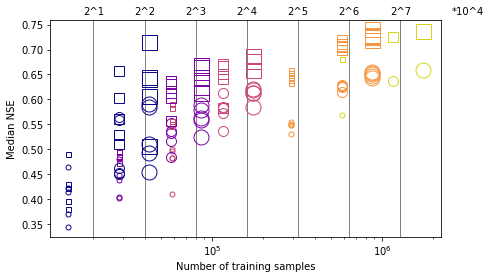

In [10]:
f, ax = plt.subplots(figsize=(7,4))

colors = {13: [0.05, 0.03, 0.53], 26:  [0.49, 0.01 , 0.66],
          53: [0.80, 0.28, 0.47], 265: [0.97, 0.59, 0.25],
          531: [0.84, 0.84, 0.13]}
markers = {'xgboost': 'o', 'ealstm': 's'}
markersize = {3: 5, 6: 10, 9: 15}
list(ax.axvline(i, color="gray", lw=1) for i in [(2**i)*(10**4) for i in range(1, 8)])
for model, name, _ in model_specs_gridEvaluation["models"]:
    for training_years, (i, n_basins) in itertools.product(model_specs_gridEvaluation['training_years'], 
                                                      enumerate(model_specs_gridEvaluation['n_basins'])):
        basin_subsets = model_specs_gridEvaluation["basin_subsets"][n_basins]
        median_nses, n_samples = [], []
        for b in basin_subsets:
            median_nses.append(np.median(list(best_seqlen_nses[training_years][b][model].values())))
            n_samples.append(training_years * 365 * n_basins)
        ax.plot(n_samples, median_nses, label=f"{name}, {training_years} years, {n_basins} basins", 
                 lw=0, marker=markers[model], c=colors[n_basins], markersize=markersize[training_years], markerfacecolor='none')

ax.set_xscale('log')
list(ax.text((2**i)*10000, 0.77, f"2^{i}", horizontalalignment='center') for i in range(1, 8))
ax.text(2**8*10000, 0.77, "*10^4")
ax.set_ylabel('Median NSE')
_ = ax.set_xlabel('Number of training samples')

## Plot change of NSE distributions with training set size

This plot aggregates the results from the above plot, and shows boxplots of NSE distributions at different orders of training set size magnitude.

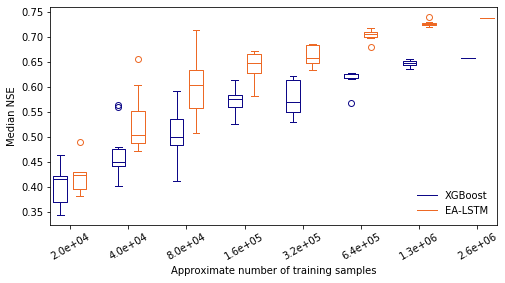

In [11]:
f = plt.figure(figsize=(8,4))

legend = []
for i, (model, name, color) in enumerate(model_specs_gridEvaluation["models"]):
    nse_dict = {20_000: [], 40_000: [], 80_000: [], 160_000: [], 
                320_000: [], 640_000: [], 1_280_000: [], 2_560_000: []}
    for training_years, n_basins in itertools.product(model_specs_gridEvaluation['training_years'], 
                                                      model_specs_gridEvaluation['n_basins']):
        basin_subsets = model_specs_gridEvaluation["basin_subsets"][n_basins]
        if any([best_seqlen_nses[training_years][b]["ealstm"] == {} for b in basin_subsets]):
            continue
        for b in basin_subsets:
            nse = np.median(list(best_seqlen_nses[training_years][b][model].values()))
            n_samples = training_years * 365 * n_basins
            for magnitude in sorted(nse_dict):
                if magnitude >= n_samples:
                    nse_dict[magnitude].append(nse)
                    break

    bp = plt.boxplot(nse_dict.values(), positions=np.arange(i, 3*len(nse_dict), 3), widths=0.7)
    for prop in ['boxes', 'caps', 'whiskers', 'medians']:
        plt.setp(bp[prop], color=color)
    plt.setp(bp['fliers'], markeredgecolor=color)
    legend.append((bp['boxes'][0], name))
    
plt.ylabel('Median NSE')
plt.xticks(np.arange(0.5,3*len(nse_dict), 3), [f"{k:.1e}" for k in nse_dict], rotation=30)
plt.legend(*zip(*legend), frameon=False, loc='lower right')
_ = plt.xlabel('Approximate number of training samples')

## Calculate statistical significance.

Calculate statistical significance between XGBoost and EA-LSTM.

In [12]:
p_values = {}
d_values = {}
for training_years in model_specs_gridEvaluation['training_years']:
    p_values[training_years] = {}
    d_values[training_years] = {}
    for n_basins in model_specs_gridEvaluation['n_basins']:
        print(f"{training_years} training years, {n_basins} basins")
        
        basin_subsets = model_specs_gridEvaluation["basin_subsets"][n_basins]
        if any([best_seqlen_nses[training_years][s]["ealstm"] == {} for s in basin_subsets]):
            continue
        xgb_nses = list(best_seqlen_nses[training_years][s]["xgboost"].values() for s in basin_subsets)
        xgb_nses = [y for x in xgb_nses for y in x]  # flatten
        ealstm_nses = list(best_seqlen_nses[training_years][s]["ealstm"].values() for s in basin_subsets)
        ealstm_nses = [y for x in ealstm_nses for y in x]  # flatten
        
        _, p_val_ks = ks_2samp(xgb_nses, ealstm_nses)
        _, p_val_wilcoxon = wilcoxon(xgb_nses, ealstm_nses)
        print(f"KS-Test: {p_val_ks:.2e}, Wilcoxon: {p_val_wilcoxon:.2e}")
        
        d_ensemble = get_cohens_d(xgb_nses, ealstm_nses)
        print(f"Effect size: Ensemble mean d={d_ensemble:.3f}")
        
        p_values[training_years][n_basins] = p_val_ks
        d_values[training_years][n_basins] = d_ensemble

3 training years, 13 basins
KS-Test: 3.95e-01, Wilcoxon: 6.24e-04
Effect size: Ensemble mean d=0.299
3 training years, 26 basins
KS-Test: 1.18e-04, Wilcoxon: 1.69e-08
Effect size: Ensemble mean d=0.248
3 training years, 53 basins
KS-Test: 4.10e-09, Wilcoxon: 4.33e-21
Effect size: Ensemble mean d=0.369
3 training years, 265 basins
KS-Test: 2.32e-59, Wilcoxon: 3.85e-160
Effect size: Ensemble mean d=0.483
3 training years, 531 basins
KS-Test: 1.16e-32, Wilcoxon: 2.26e-73
Effect size: Ensemble mean d=0.579
6 training years, 13 basins
KS-Test: 1.88e-02, Wilcoxon: 1.61e-08
Effect size: Ensemble mean d=0.287
6 training years, 26 basins
KS-Test: 4.68e-09, Wilcoxon: 5.36e-15
Effect size: Ensemble mean d=0.324
6 training years, 53 basins
KS-Test: 2.31e-10, Wilcoxon: 4.79e-22
Effect size: Ensemble mean d=0.344
6 training years, 265 basins
KS-Test: 1.63e-55, Wilcoxon: 5.72e-153
Effect size: Ensemble mean d=0.424
6 training years, 531 basins
KS-Test: 6.12e-28, Wilcoxon: 1.80e-73
Effect size: Ensemb

## Cumulative density function plot

Here we look at the CDF of the NSEs for each of our 3*5 configurations.

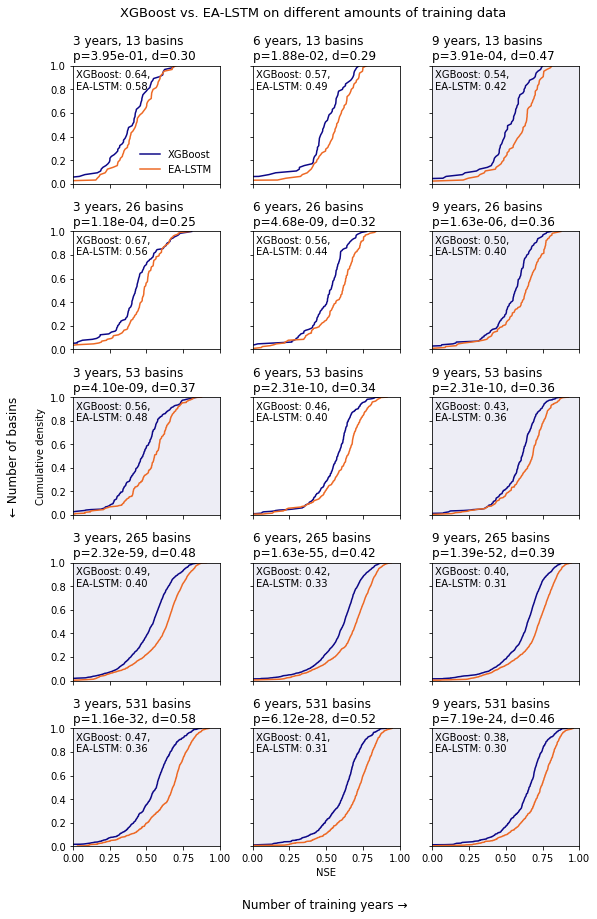

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True, figsize=(8,12))

for j, training_years in enumerate(model_specs_gridEvaluation['training_years']):
    for i, n_basins in enumerate(model_specs_gridEvaluation['n_basins']):
        ax[i,j].set_xlim(0, 1)
        ax[i,j].set_ylim(0, 1)
        if any([best_seqlen_nses[training_years][s]["ealstm"] == {} for s in model_specs_gridEvaluation['basin_subsets'][n_basins]]):
            continue
        aucs = {}
        for model, model_label, model_color in model_specs_gridEvaluation['models']:
            values = []
            for basin_subset in model_specs_gridEvaluation['basin_subsets'][n_basins]:
                values += list(best_seqlen_nses[training_years][basin_subset][model].values())
            bin_, cdf_ = ecdf(values)
            # add NSE of one to the end to count area after the highest NSE
            aucs[model] = auc(np.append(bin_, [1]), np.append(cdf_, [cdf_[-1]]))
            ax[i,j].plot(bin_, cdf_,
                         label=model_label, color=model_color)
        ax[i,j].text(0.02,0.8, f"XGBoost: {aucs['xgboost']:.2f},\nEA-LSTM: {aucs['ealstm']:.2f}")
        p_val = p_values[training_years][n_basins]
        d_val = d_values[training_years][n_basins]
        if p_val < (0.01 / 15) and d_val > 0.35:  # divide p-value by 15 for Bonferroni correction
            ax[i,j].set_facecolor((0.9,0.9,0.95,0.7))
        ax[i,j].set_title(f"{training_years} years, {n_basins} basins \np={p_val:.2e}, d={d_val:.2f}", 
                          loc='left', fontsize=12)
ax[0,0].legend(loc="lower right", frameon=False)
ax[4,1].set_xlabel('NSE')
ax[2,0].set_ylabel('Cumulative density')
fig.text(0.52, -0.02, 'Number of training years →', ha='center', va='center', fontsize=12)
fig.text(-0.02, 0.5, '← Number of basins', ha='center', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()
_ = plt.suptitle("XGBoost vs. EA-LSTM on different amounts of training data", fontsize=13, fontweight=0, color='black', y=1.02)

## Plot NSE per basin

Here we plot the models' NSE values for each basin in a heatmap, once for the models trained on all nine years and 531 basins, and once for the models trained on three years and 13 basins.

In [14]:
if not os.path.exists(BASE_CODE_DIR / "data" / "attributes.db"):
    add_camels_attributes(CAMELS_DIR)
attributes = load_attributes(db_path=BASE_CODE_DIR / "data" / "attributes.db", basins=get_basin_list(), 
                             drop_lat_lon=False, keep_features=["gauge_lat", "gauge_lon"])

nse_dict_large_train = {'xgboost': best_seqlen_nses[9][0]["xgboost"],
                        'ealstm': best_seqlen_nses[9][0]["ealstm"]}
nses_large = pd.DataFrame(nse_dict_large_train['xgboost'].values(), index=nse_dict_large_train['xgboost'].keys(), columns=["xgboost"])
nses_large = nses_large.join(pd.Series(nse_dict_large_train['ealstm'], name="ealstm"))
data_large = attributes.join(nses_large)

def merge_basin_predictions(nse_dicts):
    """ Merge a model's NSEs for different basin sets into one dictionary of average NSE per basin """
    nses = {}
    for d in nse_dicts:
        for basin, nse in d.items():
            if basin not in nses:
                nses[basin] = []
            nses[basin].append(nse)
    for basin, nse_list in nses.items():
        nses[basin] = np.mean(nse_list)
    return nses
                
nse_dict_small_train = {'xgboost': merge_basin_predictions([best_seqlen_nses[3][basin_subset]["xgboost"]
                                                            for basin_subset in model_specs_gridEvaluation['basin_subsets'][13]]),
                        'ealstm': merge_basin_predictions([best_seqlen_nses[3][basin_subset]["ealstm"]
                                                           for basin_subset in model_specs_gridEvaluation['basin_subsets'][13]])}

nses_small = pd.DataFrame(nse_dict_small_train['xgboost'].values(), index=nse_dict_small_train['xgboost'].keys(), columns=["xgboost"])
nses_small = nses_small.join(pd.Series(nse_dict_small_train['ealstm'], name="ealstm"))
data_small = attributes.join(nses_small)

/home/mgauch/miniconda3/envs/ealstm/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mgauch/miniconda3/envs/ealstm/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


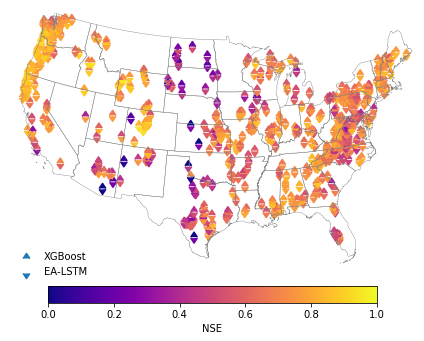

In [15]:
fig, ax = plt.subplots(figsize=(6,5))
m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
shp_info = m.readshapefile(str(BASE_CODE_DIR / 'data/st99_d00'), 'states', 
                           drawbounds=True, linewidth=0.4, color='gray')

x, y = m(data_large["gauge_lon"].values, data_large["gauge_lat"].values)  # transform coordinates
m = ax.scatter(x=x, y=y+5000, s=45, marker=10, c=data_large['xgboost'], 
                cmap='plasma', vmin=0, vmax=1, label="XGBoost")
m2 = plt.scatter(x=x, y=y-5000, s=45, marker=11, c=data_large["ealstm"], 
                 cmap='plasma', vmin=0, vmax=1, label="EA-LSTM")
ax.axis(False)
plt.legend(frameon=False, loc="lower left")
plt.colorbar(m, ax=ax, pad=0, shrink=.8, orientation='horizontal', label='NSE')
plt.tight_layout()

/home/mgauch/miniconda3/envs/ealstm/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mgauch/miniconda3/envs/ealstm/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


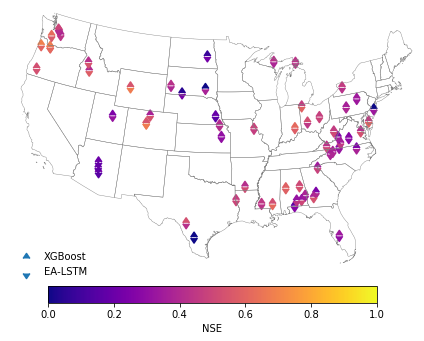

In [16]:
fig, ax = plt.subplots(figsize=(6,5))
m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
shp_info = m.readshapefile(str(BASE_CODE_DIR / 'data/st99_d00'), 'states', 
                           drawbounds=True, linewidth=0.4, color='gray')

x, y = m(data_small["gauge_lon"].values, data_small["gauge_lat"].values)  # transform coordinates
m = ax.scatter(x=x, y=y+5000, s=45, marker=10, c=data_small['xgboost'], 
                cmap='plasma', vmin=0, vmax=1, label="XGBoost")
m2 = plt.scatter(x=x, y=y-5000, s=45, marker=11, c=data_small["ealstm"], 
                 cmap='plasma', vmin=0, vmax=1, label="EA-LSTM")
ax.axis(False)
plt.legend(frameon=False, loc="lower left")
plt.colorbar(m, ax=ax, pad=0, shrink=.8, orientation='horizontal', label='NSE')
plt.tight_layout()

In [17]:
# Pearson correlation coefficients for XGBoost and EA-LSTM on the smallest and largest training sets
print("Pearson correlation coefficients")
print(" smallest training sets:", np.corrcoef(nses_small["xgboost"], nses_small["ealstm"])[0, 1])
print(" largest training set:", np.corrcoef(nses_large["xgboost"], nses_large["ealstm"])[0, 1])

Pearson correlation coefficients
 smallest training sets: 0.8405390854167889
 largest training set: 0.7808147823168368


In [18]:
# NSEs of basins on the largest training set where XBoost and EA-LSTM have strikingly different predictions
print("07299670: EA-LSTM:", best_seqlen_nses[9][0]["ealstm"]["07299670"], "XGBoost:", best_seqlen_nses[9][0]["xgboost"]["07299670"])
print("11151300: EA-LSTM:", best_seqlen_nses[9][0]["ealstm"]["11151300"], "XGBoost:", best_seqlen_nses[9][0]["xgboost"]["11151300"])

07299670: EA-LSTM: 0.0203155804074453 XGBoost: 0.726628848969451
11151300: EA-LSTM: 0.8053230831312633 XGBoost: 0.29399870397720396


In [19]:
if not PRECOMPUTED_DATA:
    for v in all_metrics:
        for vv in all_metrics[v]:
            all_metrics[v][vv] = dict(all_metrics[v][vv])
        all_metrics[v] = dict(all_metrics[v])
    all_metrics = dict(all_metrics)
    with open(BASE_RUN_DIR / "all_metrics_gridEvaluation.p", "wb") as fp:
        pickle.dump(all_metrics, fp)
    print("Stored precomputed data in 'all_metrics_gridEvaluation.p'")

In [20]:
data = []
for model, model_label, _ in model_specs_gridEvaluation["models"]:
    for training_years, n_basins, seq_len in itertools.product(model_specs_gridEvaluation['training_years'],
                                                               model_specs_gridEvaluation['n_basins'],
                                                               seq_lens[model]):
        for basin_subset in model_specs_gridEvaluation['basin_subsets'][n_basins]:
            single_model = {'model': model_label, 'ensemble': False,
                            'seq_len': seq_len,
                            'training_years': training_years,
                            'n_basins': n_basins,
                            'basin_subset': basin_subset}
            ensemble_mean = {'model': model_label, 'ensemble': True,
                             'seq_len': seq_len,
                             'training_years': training_years,
                             'n_basins': n_basins,
                             'basin_subset': basin_subset}
            # average over single models
            for metric, metric_data in all_metrics.items():
                seeds = [k for k in metric_data[model][training_years][seq_len][basin_subset].keys() if "seed" in k]
                seed_vals = defaultdict(list)
                for seed in seeds:
                    values = list(metric_data[model][training_years][seq_len][basin_subset][seed].values())
                    seed_vals[f"{metric} median"].append(np.median(values))
                    if metric == "NSE":
                        seed_vals[f"{metric} mean"].append(np.mean(values))
                        seed_vals["failures"].append(len([v for v in values if v <= 0]))
                    single_model[f"{metric} median"] = np.mean(seed_vals[f"{metric} median"])
                    single_model[f"{metric} median std"] = np.std(seed_vals[f"{metric} median"])
                    if metric == "NSE":
                        single_model[f"{metric} mean"] = np.mean(seed_vals[f"{metric} mean"])
                        single_model[f"{metric} mean std"] = np.std(seed_vals[f"{metric} mean"])
                        single_model[f"failures"] = np.mean(seed_vals["failures"])
                        single_model[f"failures std"] = np.std(seed_vals["failures"])

                # ensemble mean
                values = list(metric_data[model][training_years][seq_len][basin_subset]["ensemble"].values())
                ensemble_mean[f"{metric} median"] = np.median(values)
                if metric == "NSE":
                    ensemble_mean["NSE mean"] = np.mean(values)
                    ensemble_mean["failures"] = len([v for v in values if v <= 0])
            data.append(single_model)
            data.append(ensemble_mean)
        
df = pd.DataFrame(data)
df = df.set_index(keys=["training_years", "n_basins", "basin_subset", "ensemble", "model", "seq_len"])
df.sort_values(["training_years", "n_basins", "basin_subset", "ensemble", "model", "seq_len"], inplace=True)
df

FHV median  \
training_years n_basins basin_subset ensemble model   seq_len               
3              13       16           False    EA-LSTM 10       -48.141311   
                                                      30       -59.214668   
                                                      100      -74.203020   
                                                      270      -74.724322   
                                                      365      -71.282246   
                                              XGBoost 10       -44.630545   
                                                      30       -66.462193   
                                                      100      -74.929364   
                                     True     EA-LSTM 10       -47.305407   
                                                      30       -60.899462   
                                                      100      -76.448485   
                                                      270      -76.132173   
                                                      365      -73.412512   
                                              XGBoost 10       -45.185951   
                                                      30       -66.616092   
                                                      100      -75.676627   
                        17           False    EA-LSTM 10       -51.484137   
                                                      30       -63.702130   
                                                      100      -80.940601   
                                                      270      -81.252032   
                                                      365      -83.184220   
                                              XGBoost 10       -51.675513   
                                                      30       -66.228046   
                                                      100      -78.048685   
                                     True     EA-LSTM 10       -51.359182   
                                                      30       -66.544024   
                                                      100      -82.102527   
                                                      270      -83.224881   
                                                      365      -84.499185   
                                              XGBoost 10       -53.180837   
...                                                                   ...   
9              265      5            False    EA-LSTM 100      -16.264843   
                                                      270      -16.816815   
                                                      365      -17.132819   
                                              XGBoost 10       -29.710839   
                                                      30       -27.535254   
                                                      100      -33.011853   
                                     True     EA-LSTM 10       -18.155537   
                                                      30       -15.519351   
                                                      100      -17.446977   
                                                      270      -17.837878   
                                                      365      -18.047218   
                                              XGBoost 10       -30.239398   
                                                      30       -27.696894   
                                                      100      -33.487758   
               531      0            False    EA-LSTM 10       -20.111642   
                                                      30       -17.095066   
                                                      100      -17.393940   
                                                      270      -17.942819   
                                                      365      -18.618568   
                                              XGBoost 10   